<td>
   <a target="_blank" href="https://labelbox.com" ><img src="https://labelbox.com/blog/content/images/2021/02/logo-v4.svg" width=256/></a>
</td>

<td>
<a href="https://colab.research.google.com/github/Labelbox/labelbox-python/blob/develop/examples/model_assisted_labeling/mal_with_subclasses.ipynb" target="_blank"><img
src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"></a>
</td>

<td>
<a href="https://github.com/Labelbox/labelbox-python/tree/develop/examples/model_assisted_labeling/mal_with_subclasses.ipynb" target="_blank"><img
src="https://img.shields.io/badge/GitHub-100000?logo=github&logoColor=white" alt="GitHub"></a>
</td>

# MAL With Subclasses
* Image MAL with subclasses.
* This is the same task as the image mal tutorial but we are going to add a subclass for whether or not the person in the image is holding a bag.

In [1]:
!pip install labelbox
!pip install numpy
!pip install tensorflow

In [2]:
# Run these if running in a colab notebook
COLAB = "google.colab" in str(get_ipython())
if COLAB:
    !git clone https://github.com/Labelbox/labelbox-python.git
    !mv labelbox-python/examples/model_assisted_labeling/image_model.py .

In [3]:
#Used this as a reference for the model
#https://colab.research.google.com/github/tensorflow/tpu/blob/master/models/official/mask_rcnn/mask_rcnn_demo.ipynb#scrollTo=6lCL-ZcwaJbA
from labelbox.schema.ontology import OntologyBuilder, Tool, Classification, Option
from labelbox.schema.media_type import MediaType
from labelbox import Client, LabelingFrontend
from image_model import predict, class_mappings, load_model
from typing import Dict, Any, Tuple, List
import numpy as np
from PIL import Image
import requests
import ndjson
import uuid
from io import BytesIO
import os

# API Key and Client
Provide a valid api key below in order to properly connect to the Labelbox Client.

In [6]:
# Add your api key
API_KEY = None
client = Client(api_key=API_KEY)

In [7]:
#Downloads weights and loads the model.
load_model()

Instructions for updating:
This function will only be available through the v1 compatibility library as tf.compat.v1.saved_model.loader.load or tf.compat.v1.saved_model.load. There will be a new function for importing SavedModels in Tensorflow 2.0.
INFO:tensorflow:Restoring parameters from gs://cloud-tpu-checkpoints/mask-rcnn/1555659850/variables/variables


### Project Setup

In [8]:
# Add handbag classification
ontology_builder = OntologyBuilder(tools=[
    Tool(tool=Tool.Type.BBOX,
         name="person",
         classifications=[
             Classification(
                 class_type=Classification.Type.RADIO,
                 name="has_handbag",
                 options=[Option(
                     value="True"), Option(value="False")])
         ]),
])

In [9]:
# Lets setup a project to label
# Note see Ontology, Project, and Project_setup notebooks for more information on this section.
project = client.create_project(name="subclass_mal_project", media_type=MediaType.Image)
dataset = client.create_dataset(name="subclass_mal_dataset")
test_img_url = "https://raw.githubusercontent.com/Labelbox/labelbox-python/develop/examples/assets/2560px-Kitano_Street_Kobe01s5s4110.jpg"
dataset.create_data_row(row_data=test_img_url)
editor = next(
    client.get_labeling_frontends(where=LabelingFrontend.name == 'editor'))
project.setup(editor, ontology_builder.asdict())
project.datasets.connect(dataset)

In [10]:
project.enable_model_assisted_labeling()

True

### Grab featureSchemaIds

In [11]:
# When we created a project with the ontology defined above, all of the ids were assigned.
# So lets reconstruct the ontology builder with all of the ids.
ontology = ontology_builder.from_project(project)
# We want all of the feature schemas to be easily accessible by name.
ontology

OntologyBuilder(tools=[Tool(tool=<Type.BBOX: 'rectangle'>, name='person', required=False, color='#ff0000', classifications=[Classification(class_type=<Type.RADIO: 'radio'>, instructions='has_handbag', required=False, options=[Option(value='True', schema_id='ckmoz8mfj0xgg0y96287c680o', feature_schema_id='ckmoz8mfj0xgh0y96ayy2cu9g', options=[]), Option(value='False', schema_id='ckmoz8mfk0xgi0y96bu523ijh', feature_schema_id='ckmoz8mfk0xgj0y96de0g35o3', options=[])], schema_id='ckmoz8mex0xge0y96djq5dcih', feature_schema_id='ckmoz8mex0xgf0y96fjxef4pk')], schema_id='ckmoz8me90xgc0y968wridwvh', feature_schema_id='ckmoz8me90xgd0y962z62fqv6')], classifications=[])

In [12]:
box_feature_schema_id = ontology.tools[0].feature_schema_id
has_bag_feature_schema_id = ontology.tools[0].classifications[
    0].feature_schema_id
true_feature_schema_id = ontology.tools[0].classifications[0].options[
    0].feature_schema_id
false_feature_schema_id = ontology.tools[0].classifications[0].options[
    1].feature_schema_id

### Create import objects
* We want to create a json payload that matches this: https://docs.labelbox.com/data-model/en/index-en#annotations
* Here we will run inferences on all of our data (only one image this time)

##### Create helper functions to make this much easier

In [13]:
def create_radio_subclass_ndjson(schema_id: str,
                                 option_schema_id: str) -> Dict[str, Any]:
    """
    Args:
        schema_id (str): id of the radio tool in the current ontology
        option_schema_id (str): id of the option selected
    Returns:
        ndjson for the radio classification
    """
    return {'schemaId': schema_id, 'answer': {'schemaId': option_schema_id}}


def create_box_ndjson(datarow_id: str, schema_id: str, t: float, l: float,
                      b: float, r: float) -> Dict[str, Any]:
    """
    
    Args:
        datarow_id (str): id of the data_row (in this case image) to add this annotation to
        schema_id (str): id of the bbox tool in the current ontology
        t, l, b, r (int): top, left, bottom, right pixel coordinates of the bbox
    Returns:
        ndjson for bounding boxes
    """
    return {
        "uuid": str(uuid.uuid4()),
        "schemaId": schema_id,
        "dataRow": {
            "id": datarow_id
        },
        "bbox": {
            "top": int(t),
            "left": int(l),
            "height": int(b - t),
            "width": int(r - l)
        },
    }


def has_bag(person_box: Tuple[float, float, float, float],
            bag_centroids: List[Tuple[float, float]]) -> bool:
    """
    A person has a bag if the centoid of the box is predicted within the bounding box of the person
    
    Args:
        person_box (Tuple[float, float, float, float]): top, left, bottom, right pixel coordinates of the bbox
        bag_centroids (List[Tuple[float, float]]) : list of y,x coordinates indicating the center of the box
    Returns:
        bool indicating whether or not the person has a bag
    """
    # Check if the person has a bag.
    for bag_centroid in bag_centroids:
        if (person_box[0] < bag_centroid[0] and
                person_box[2] > bag_centroid[0] and
                person_box[1] < bag_centroid[1] and
                person_box[3] > bag_centroid[1]):
            return True

* Loop over data_rows, make predictions, and create ndjson

In [14]:
ndjsons = []
for data_row in dataset.data_rows():
    np_image_bytes = np.array([requests.get(data_row.row_data).content])
    w, h = Image.open(BytesIO(np_image_bytes[0])).size
    prediction = predict(np_image_bytes, min_score=0.5, height=h, width=w)
    boxes, classes, seg_masks = prediction['boxes'], prediction[
        'class_indices'], prediction['seg_masks']
    people_boxes = []
    bag_boxes = []
    for box, class_idx, seg in zip(boxes, classes, seg_masks):
        class_name = class_mappings[class_idx]
        if class_name == "handbag":
            bag_boxes.append(box)
        elif class_name == "person":
            people_boxes.append(box)

    bag_centroids = [
        [(box[0] + box[2]) / 2, (box[1] + box[3]) / 2] for box in bag_boxes
    ]
    for person in people_boxes:
        person_ndjson = create_box_ndjson(data_row.uid, box_feature_schema_id,
                                          *person)
        if has_bag(person, bag_boxes):
            option_feature_schema = true_feature_schema_id
        else:
            option_feature_schema = false_feature_schema_id

        bag_classification = create_radio_subclass_ndjson(
            has_bag_feature_schema_id, option_feature_schema)
        person_ndjson.update({"classifications": [bag_classification]})
        ndjsons.append(person_ndjson)

In [15]:
print(ndjsons[3])

{'uuid': '74c9bee0-32dc-42ee-ae0c-f84ad9dea85b', 'schemaId': 'ckmoz8me90xgd0y962z62fqv6', 'dataRow': {'id': 'ckmoz8kwm1nvl0y6v2irpcdjw'}, 'bbox': {'top': 1268, 'left': 437, 'height': 424, 'width': 145}, 'classifications': [{'schemaId': 'ckmoz8mex0xgf0y96fjxef4pk', 'answer': {'schemaId': 'ckmoz8mfj0xgh0y96ayy2cu9g'}}]}


In [16]:
print(ndjsons[1])
from labelbox.schema.bulk_import_request import _validate_ndjson

_validate_ndjson([ndjsons[1]], project)
print("after...")
print(ndjsons[1])

{'uuid': 'e15a4170-d5b6-4565-9f8b-87e3260d411f', 'schemaId': 'ckmoz8me90xgd0y962z62fqv6', 'dataRow': {'id': 'ckmoz8kwm1nvl0y6v2irpcdjw'}, 'bbox': {'top': 1250, 'left': 2088, 'height': 429, 'width': 158}, 'classifications': [{'schemaId': 'ckmoz8mex0xgf0y96fjxef4pk', 'answer': {'schemaId': 'ckmoz8mfj0xgh0y96ayy2cu9g'}}]}
after...
{'uuid': 'e15a4170-d5b6-4565-9f8b-87e3260d411f', 'schemaId': 'ckmoz8me90xgd0y962z62fqv6', 'dataRow': {'id': 'ckmoz8kwm1nvl0y6v2irpcdjw'}, 'bbox': {'top': 1250, 'left': 2088, 'height': 429, 'width': 158}, 'classifications': [{'schemaId': 'ckmoz8mex0xgf0y96fjxef4pk', 'answer': {'schemaId': 'ckmoz8mfj0xgh0y96ayy2cu9g'}}]}


### Upload the annotations

In [17]:
# Let's upload!
upload_task = project.upload_annotations(name=f"upload-job-{uuid.uuid4()}",
                                         annotations=ndjsons,
                                         validate=True)

In [18]:
# Wait for upload to finish (Will take up to five minutes)
upload_task.wait_until_done()
# Review the upload status
print(upload_task.errors)

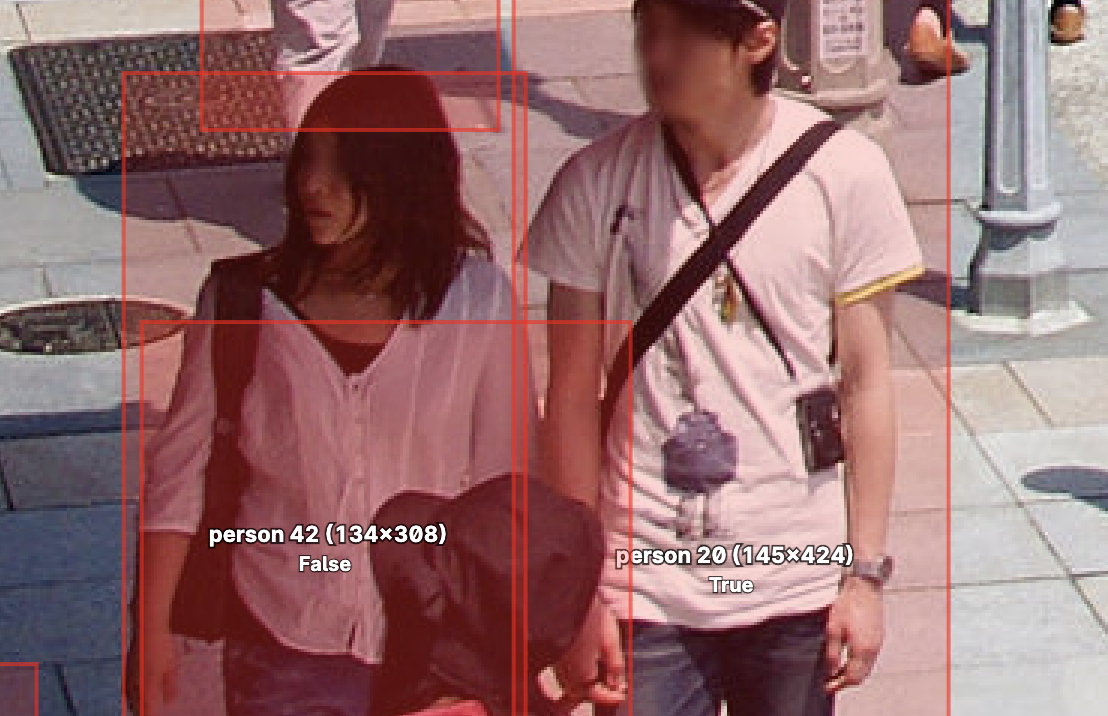

In [19]:
#We can see that the upload worked. Although our heuristic or the model made a mistake.